# Project: Ubiquitous Computing Project 2

Date: 05.2021

Authors: 
 * Rayan Armani [rarmani@ethz.ch]
 * Massimo Albarello [malbarello@ethz.ch]

## 0. Importing data and necessary libraries


In [137]:
import pickle5 as pickle 
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt

with open("ex2_recordings/participant_01.pkl", "rb") as f:
    particiapnt_01_data = pickle.load(f)

    print(particiapnt_01_data["recordings"].keys())


dict_keys([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36])


## 1. Feature extraction and data analysis

### 1.1 ECG

#### a) Plotting the PSD
The Lead I ECG signal is the difference between the sensor measurements of the left and right arms. To find its Power Spectral Density we use Welch's method such as in Abadi et al.  

References:
* [scipy.signal.welch](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.welch.html)
* [Mojtaba Khomami Abadi, Ramanathan Subramanian, Seyed Mostafa Kia, Paolo Avesani, Ioannis Patras, and Nicu Sebe. Decaf: Meg-based multimodal database for decoding affective physiological responses. *IEEE Transactions on Affective Computing*, 6(3):209–222, 2015 ](https://stefan.winkler.site/Publications/tac2015.pdf)

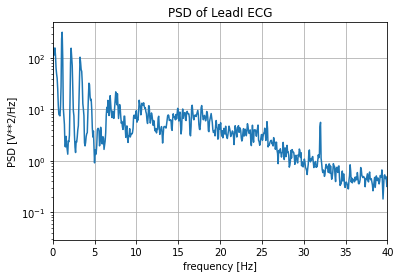

In [95]:
# Extract sampling frequency of ECG
ECG_freq = particiapnt_01_data["FS_ECG"]

# Extract Lead I ECG (left_hand - right hand) signal of the first participant watching clip 1
raw_ECG_p1 = np.array(particiapnt_01_data["recordings"][1]["ECG"])

lead1_ecg_p1= np.array(raw_ECG_p1[:,1]-raw_ECG_p1[:,2])
# lead1_ecg_p1= np.array(raw_ECG_p1[:,1])

# Parameters for calculating the PSD 
# From [1] in exercise handout: Welch method using window length of 15xsr overlap 10xsr where sr denotes sampling rate
f, Pxx_den = signal.welch(x=lead1_ecg_p1, fs= ECG_freq, nperseg = 15*ECG_freq, noverlap= 10*ECG_freq, scaling='density', average='mean')

plt.semilogy(f, Pxx_den)
plt.xlim(0,40)
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD [V**2/Hz]')
plt.title('PSD of LeadI ECG')
plt.grid(True)
plt.show()


#### b) Signal filtering

The raw Lead I ECG is inherently noisy, as shown by the presence of high frequency components as revealed in the PSD. Features of interest in an ECG however, are in the lower frequency ranges. From the PSD plot, we can infer that the signal's most significant components lie in the [0-20Hz] range. As such we can design a low pass filter to remove noise components with frequencies above 20Hz, using scipy's implementation of a Butterworth filter. When we plot the results from a simple low pass filter, we notice the baseline is not stable. To reduce the effect of a wandering baseline, we add a high pass filter at 4Hz. We can combine both filters in a bandapss filter over [4-20Hz] 
Notes: **most papers I reaad mentioned filtering with a cutoff at 20Hz ex: https://www.hindawi.com/journals/cmmm/2015/453214/

References: 
* [scipy.signal.butter](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.butter.html)
* [scipy repository on github](https://scipy.github.io/old-wiki/pages/Cookbook/ButterworthBandpass)


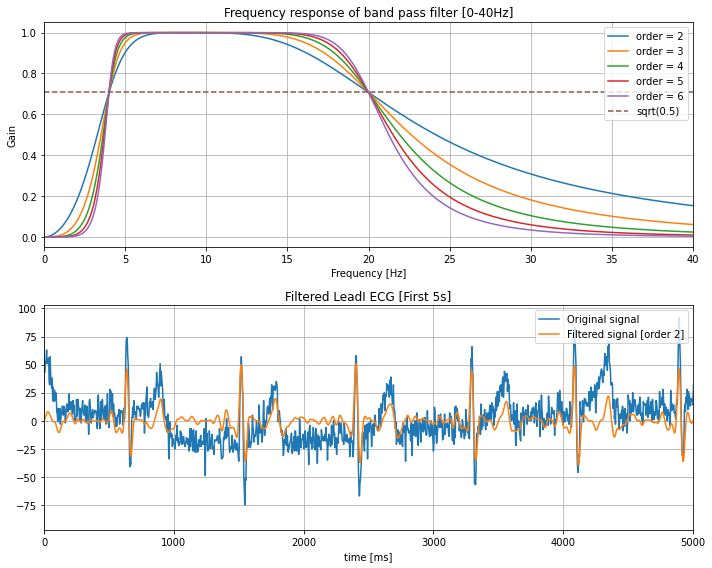

In [116]:
# Low pass filter definition functions
def butter_bandpass(lowcut, highcut,fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = signal.butter(order,[low,high], btype='bandpass')
    return b, a


def butter_bandpass_filter(data, lowcut, highcut, fs, order):
    b, a = butter_bandpass(lowcut, highcut, fs, order)
    y = signal.filtfilt(b, a, data)
    return y
# Low pass filter implementation
# Parameters
lowcut = 4 #[Hz]
highcut = 20
fs = ECG_freq

# Plot the frequency response for a few different orders.
fig, ax = plt.subplots(nrows=2,ncols=1,figsize=(10, 8), sharex=False)

for order in [2,3,4,5,6]:
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    w, h = signal.freqz(b, a, worN=2000)
    ax[0].plot((fs * 0.5 / np.pi) * w, abs(h), label="order = %d" %order)

ax[0].plot([0, 0.5 * fs], [np.sqrt(0.5), np.sqrt(0.5)],'--', label='sqrt(0.5)')
ax[0].set_xlabel('Frequency [Hz]')
ax[0].set_xlim(0,40)
ax[0].set_ylabel('Gain')
ax[0].grid(True)
ax[0].set_title('Frequency response of band pass filter [0-40Hz]') 
ax[0].legend(loc='upper right')

# Choose filter order
order = 2
# Apply the low pass filer to the lead I ECG filter
filtered_lead1_ecg_p1 = butter_bandpass_filter(lead1_ecg_p1,lowcut, highcut, fs, order)

# Get time 
t = np.array(raw_ECG_p1[:,0]) - raw_ECG_p1[0,0] #[ms]

# Plot the first 5s of the filtered signal in time domain
ax[1].plot(t,lead1_ecg_p1, label='Original signal')
ax[1].plot(t,filtered_lead1_ecg_p1, label='Filtered signal [order %d]' %order)
ax[1].set_xlabel('time [ms]')
ax[1].set_xlim(0,5000)
ax[1].grid(True)
ax[1].set_title('Filtered LeadI ECG [First 5s]') 
ax[1].legend(loc='upper right')
plt.tight_layout()
plt.show()

#### c) Artifact detection 

 

References: 

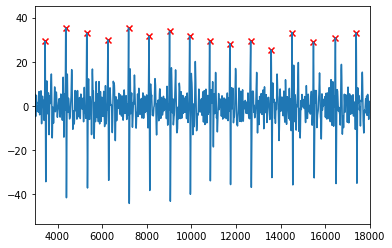

In [162]:
# Utility functions for artifact detection algorithm
def get_RRI(ecg_signal, fs):
    '''
    Return the RR peak interval for a signal, in ms. Uses scipy's find peaks algorithm. 
    '''
    peaks, _ = signal.find_peaks(ecg_signal, height= 25 , threshold= None, distance=200, prominence= None)
    RRI = np.diff(peaks)
    RRI_ms = RRI*1000/fs
    return RRI_ms, peaks

def get_CBD(RRI):
    '''
    Return the Criterion Beat Differece for the RR intervals of an ECG signal 
    '''
    Q1 = np.percentile(RRI, 0.25)
    Q2 = np.percentile(RRI, 0.5)
    Q3 = np.percentile(RRI, 0.75)

    QD = (Q3-Q1)/2.0 # Quartile Deviation
    MAD = (Q2-2.9*QD)/3.0
    MED = 3.32*QD

    CBD =(MAD+MED)/2.0
    return CBD

def detect_artifacts(ecg_signal, fs):
    '''
    Detects artifacts in ECG signal. Input needs to be filtered ecg
    '''
    has_artifacts = False
    RRI, peaks = get_RRI(ecg_signal, fs)
    CBD = get_CBD(RRI)

    last_valid_RRI = 0
    valid_RRI_indices = np.ones((1,len(RRI))).reshape(-1,1)
    for i in range(1,len(RRI)-1):
        if RRI[i-1] >= 300 and RRI[i-1]<=2000:
            if abs(RRI[i]-RRI[i-1])<=CBD:
                valid_RRI_indices[i]=1
            else: 
                valid_RRI_indices[i]=0
        else:
            if abs(RRI[i]-last_valid_RRI)<=CBD:
                valid_RRI_indices[i]=1
            else:
                if abs(RRI[i]-RRI[i-1])<=CBD and abs(RRI[i]-RRI[i+1])<=CBD:
                    valid_RRI_indices[i]=1
                else:
                    valid_RRI_indices[i]=0

    # Count artifacts
    n_artifacts = len(RRI)-np.sum(valid_RRI_indices)
    if n_artifacts > 0:
        has_artifacts = True
    return has_artifacts, n_artifacts, valid_RRI_indices, peaks

raw_ECG = np.array(particiapnt_01_data["recordings"][2]["ECG"])
lead1_ecg = np.array(raw_ECG[:,1]-raw_ECG[:,2])
t = np.array(raw_ECG[:,0]) - raw_ECG[0,0] #[ms]
filtered_ecg = butter_bandpass_filter(lead1_ecg,lowcut, highcut, fs, order)
a, n_a, idx , peaks= detect_artifacts(filtered_ecg, fs)
plt.plot(t,filtered_ecg)
plt.scatter(peaks*1000/fs, filtered_ecg[peaks], marker = 'x', color = 'r')
plt.xlim(300*10, 300*60)
plt.show()

# # load ECG data
# total_data = 0 
# for i in range(45):
#     if i<10:
#         pn = "0"+str(i+1)
#     else: 
#         pn= str(i+1) 
#     with open("ex2_recordings/participant_%s.pkl" %pn, "rb") as f:
#         participant_data = pickle.load(f)

#         # Extract sampling frequency of ECG
#         fs = participant_data["FS_ECG"]

#         # Clips
#         clip_ids=participant_data["recordings"].keys()
#         # Extract ECG for each clip 
#         for clip in clip_ids:
#             raw_ECG= np.array(participant_data["recordings"][clip]["ECG"])
#             # Get lead1 ECG signal
#             lead1_ecg= np.array(raw_ECG[:,1]-raw_ECG[:,2])

#             # Filter ECG signal
#             filtered_lead1_ecg = butter_bandpass_filter(lead1_ecg,lowcut, highcut, fs, order)
            
#             # Check for artifacts
#             if detect_artifacts(filtered_lead1_ecg, fs):
#                 print("Patient {:s} Clip {:d} has artifacts".format(pn, clip))




#### d) Feature extraction

References: 

#### e) Extraction of additional features 

References: 

### 1.2 EMO
Text explanations can go here or in between python cells in the following parts

In [ ]:
# Answers for facial movement processing task 

### 1.3 EDA
Text explanations can go here or in between python cells in the following parts

### 1.4 Valence and arousal
Text explanations can go here or in between python cells in the following parts

## 2. Classification
Text explanations can go here or in between python cells in the following parts